In [167]:
import numpy as np
import pandas as pd 
import gc

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

from sklearn.metrics import roc_curve

In [103]:


promotedcontent = pd.read_csv('promoted_content.csv')
documentCategory = pd.read_csv('documents_categories.csv')
documentEntity = pd.read_csv('documents_entities.csv')
documentTopic = pd.read_csv('documents_topics.csv')


In [28]:
# Read Clicks_Train  Data
clicksTrain  = pd.read_csv('clicks_train.csv',nrows=999999)

In [31]:
clicksTrain.shape

(999999, 3)

In [ ]:
# Read Clicks_Test  Data
clicksTest = pd.read_csv('clicks_test.csv',nrows=999999)

In [ ]:
clicksTest.shape

In [2]:
# Read Events Data
eventsData = pd.read_csv('events.csv',nrows=999999)

E:\Users\703214567\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mergedData_Event = pd.DataFrame(eventsData)

In [4]:
#Split geo_location into country
mergedData_Event['Country']=mergedData_Event['geo_location'].str[0:2]

In [5]:
mergedData_Event.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,Country
0,1,cb8c55702adb93,379743,61,3,US>SC>519,US
1,2,79a85fa78311b9,1794259,81,2,US>CA>807,US
2,3,822932ce3d8757,1179111,182,2,US>MI>505,US
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564,US
4,5,8d0daef4bf5b56,252458,338,2,SG>00,SG


In [7]:
mergedData_Event['Country'].head()

0    US
1    US
2    US
3    US
4    SG
Name: Country, dtype: object

In [9]:
#Remove geo_location and keep country
mergedData_Event.drop(['geo_location'],axis=1,inplace=True)
mergedData_Event.head(1)

,display_id,uuid,document_id,timestamp,platform,Country
0,1,cb8c55702adb93,379743,61,3,US


In [11]:
def splitDataFrameIntoSmaller(dfs, chunkSize = 15000):
    dataframes = list()
    chunk_number = len(dfs) // chunkSize + 1
    for i in range(chunk_number):
        dataframes.append(dfs[i*chunkSize:(i+1)*chunkSize])
    return dataframes

In [14]:
# Apply below function on Clicks_Train.csv to Split data into chunks 
split_clicksTrain = splitDataFrameIntoSmaller(clicksTrain)

In [24]:
chunkData = split_clicksTrain[0]

In [ ]:
Merge Events Data with clicksTrain

In [26]:
# merge mergedData_Event with chunkData using display_id
mergedData_Events = pd.merge(chunkData,mergedData_Event,how='left',on=(['display_id']))

In [56]:
mergedData_Events.head(1)

,display_id,ad_id,clicked,uuid,document_id,timestamp,platform,Country
0,1,42337,0,cb8c55702adb93,379743,61,3,US


In [82]:
# merge mergedData_Events with promotedcontent using ad_id
mergedDataSet = pd.merge(mergedData_Events,promotedcontent,how='left',on=(['ad_id']))


In [83]:
# get documentCategory datamerged_df_with_CL_Cat = pd.merge(merged_df,average_category_confidenceLevel,how='left',on='document_id') group by document_id  & confidence_level
DocumentCat_ConfidenceLevel = pd.DataFrame(documentCategory.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [85]:
# merge mergedData with DocumentCat_ConfidenceLevel using document_id

mergedDataSet_Category = pd.merge(mergedDataSet,DocumentCat_ConfidenceLevel,how='left',on=(['document_id']))

In [87]:
mergedDataSet_Category.to_csv('mergedDataSet_Category.csv',index=None)

In [88]:
mergedDataSet_Category = mergedDataSet_Category[np.isfinite(mergedDataSet_Category['confidence_level'])]

In [90]:
# Format on confidence_level
mergedDataSet_Category['confidence_level'] = mergedDataSet_Category['confidence_level'].map('{:,.3f}'.format)

E:\Users\703214567\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


E:\Users\703214567\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [96]:
topic_confidenceLevel = pd.DataFrame(documentTopic.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [98]:
# Merge Document_Topics.csv with mergedDataSet_Category
mergedDataSet_Topic = pd.merge(mergedDataSet_Category,topic_confidenceLevel,how='left',on='document_id')

In [100]:
mergedDataSet_Topic = mergedDataSet_Topic[np.isfinite(mergedDataSet_Topic['confidence_level_y'])]

In [102]:
mergedDataSet_Topic['confidence_level_y'] = mergedDataSet_Topic['confidence_level_y'].map('{:,.3f}'.format)

E:\Users\703214567\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
# Merge Document_Entities.csv with 
entity_confidenceLevel = pd.DataFrame(documentEntity.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [109]:
meragedDataSet_Entities = pd.merge(mergedDataSet_Topic,entity_confidenceLevel,how='left',on='document_id')

In [110]:
meragedDataSet_Entities.to_csv("meragedDataSet_Entities.csv")

In [114]:
gc.collect()

180

In [183]:
meragedDataSet_Entities = meragedDataSet_Entities[np.isfinite(meragedDataSet_Entities['confidence_level'])]

In [184]:
meragedDataSet_Entities['confidence_level'] = meragedDataSet_Entities['confidence_level'].map('{:,.3f}'.format)

In [213]:
meragedDataSet_Entities.to_csv("Document_Metadata.csv", index=False)

AttributeError: 'dict' object has no attribute 'to_csv'

In [212]:
if 'uuid' in meragedDataSet_Entities.columns: meragedDataSet_Entities.drop(['uuid'],axis=1,inplace=True) 
if 'timestamp' in meragedDataSet_Entities.columns: meragedDataSet_Entities.drop(['timestamp'],axis=1,inplace=True) 
if 'document_id' in meragedDataSet_Entities.columns: meragedDataSet_Entities.drop(['document_id'],axis=1,inplace=True) 

#meragedDataSet_Entities.drop_duplicates(subset=['display_id', 'ad_id_x'], keep=False)
    
document_metadata = pd.read_csv("Document_Metadata.csv")
document_metadata.head()

AttributeError: 'dict' object has no attribute 'columns'

In [267]:
import csv
from collections import defaultdict

result = defaultdict(list)  # each entry of the dict is, by default, an empty list

with open('Document_Metadata.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in csvreader:
        result[row[0]].append(row[1])

    sorted_data = {x:sorted(result[x]) for x in sorted(result.keys(),reverse=True)}
    #sorted_data =[ sorted_data(y,[x]) for x,y in sorted(result.items(),reverse=True)]
#sorted(cityPopulation.items(), key=lambda k_v: k_v[1][2], reverse=True)

#sorted_data.sort(key=takeSecond)


sorted_data 

{'display_id': ['ad_id_x'],
 '98': ['102724',
  '102724',
  '127051',
  '127051',
  '127712',
  '127712',
  '163664',
  '163664',
  '190063',
  '190063',
  '5292',
  '5292'],
 '979': ['233887', '68289'],
 '962': ['141596', '152140'],
 '956': ['154251',
  '154251',
  '41418',
  '41418',
  '49707',
  '49707',
  '54512',
  '54512',
  '62672',
  '62672'],
 '954': ['129028',
  '129028',
  '187175',
  '187175',
  '188282',
  '188282',
  '235535',
  '235535',
  '270121',
  '270121'],
 '951': ['213828', '81647'],
 '95': ['122740',
  '122740',
  '141317',
  '141317',
  '189226',
  '189226',
  '37416',
  '37416',
  '40529',
  '40529'],
 '946': ['153783', '153783', '168522', '168522'],
 '945': ['112802',
  '112802',
  '43180',
  '43180',
  '43838',
  '43838',
  '71694',
  '71694'],
 '936': ['146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '146148',
  '1461

In [268]:
Model Creation

SyntaxError: invalid syntax (<ipython-input-268-c527dcd23663>, line 1)

In [150]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for CName in meragedDataSet_Entities.columns:
    if meragedDataSet_Entities[CName].dtype == object:
        meragedDataSet_Entities[CName] = le.fit_transform(meragedDataSet_Entities[CName])
    else:
        pass

In [173]:
meragedDataSet_Entities = meragedDataSet_Entities[np.isfinite(meragedDataSet_Entities['ad_id_y'])]
meragedDataSet_Entities = meragedDataSet_Entities[np.isfinite(meragedDataSet_Entities['advertiser_id'])]
meragedDataSet_Entities = meragedDataSet_Entities[np.isfinite(meragedDataSet_Entities['campaign_id'])]


In [174]:
X = [x for x in meragedDataSet_Entities.columns if x not in ['display_id','clicked']]
x = meragedDataSet_Entities[X]
print(x)

       ad_id_x  platform  Country   ad_id_y  campaign_id  advertiser_id  \
6       125211         1       31  350091.0        108.0          176.0   
7       125211         1       31  350119.0        841.0          176.0   
8       156535         1       31  350091.0        108.0          176.0   
9       156535         1       31  350119.0        841.0          176.0   
10      169564         1       31  350091.0        108.0          176.0   
11      169564         1       31  350119.0        841.0          176.0   
12      308455         1       31  350091.0        108.0          176.0   
13      308455         1       31  350119.0        841.0          176.0   
114     139944         1       31  332501.0        841.0          176.0   
115     139944         1       31  332616.0        108.0          176.0   
116     166549         1       31  332501.0        841.0          176.0   
117     166549         1       31  332616.0        108.0          176.0   
118     181548         1 

In [175]:
Y = ['clicked']
y = meragedDataSet_Entities[Y]
y = np.ravel(y)
print(y)

[0 0 0 ... 0 1 1]


In [176]:
Xtrain, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
##print(X_test)
print(y_train)
print(X_test)

print(Xtrain)
print(y_test)

[0 0 1 ... 0 0 0]
       ad_id_x  platform  Country   ad_id_y  campaign_id  advertiser_id  \
26735   195059         1        2    6098.0       1136.0          617.0   
11169   228959         0       31  450564.0      31564.0         1593.0   
25935    63889         1       31  319718.0      25886.0          112.0   
28266    92434         0       19  443532.0      14239.0         1634.0   
30516    84154         1       31  450568.0      31564.0         1593.0   
4749    215848         1       31  347670.0        108.0          176.0   
31511   172031         1       31  257720.0      26508.0         1593.0   
23820   229120         1       31   45093.0       2105.0           53.0   
6756    109539         0        1  442416.0       3726.0         1634.0   
31557   172031         1       31  361438.0      28176.0         1593.0   
31929   182130         1       31  452748.0      31607.0         1593.0   
10812   173005         0       31  292560.0      21847.0         1593.0   
27437  

In [177]:
model = RandomForestClassifier(random_state=1, n_estimators=3, min_samples_split=4, min_samples_leaf=2, n_jobs=3)

In [178]:
train_model = model.fit(Xtrain,y_train)

In [234]:
print(model.score(X_test,y_test))

0.9666780006800408


In [231]:
pred = train_model.predict_proba(X_test)

In [242]:
pred

array([[0.88888889, 0.11111111],
       [1.        , 0.        ],
       [0.11111111, 0.88888889],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

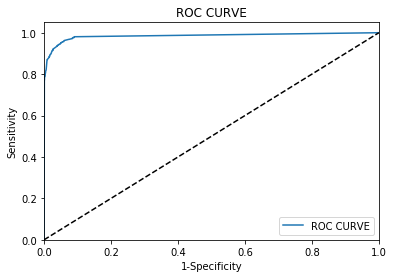

In [241]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()